# MutSig result analysis

- come up with a list to look at in IGV

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [2]:
#def subset(dir_name):
dir_name = "/demo-mount/smk_gs/smk-ms/res/BRCA"
sig_maf = pd.read_csv(dir_name+"/final_analysis_set.maf", sep = "\t")
gene_dict = loadmat(dir_name+"/input_data.M/gene/name.mat")
gene_dict = loadmat(dir_name+"/input_data.M/gene/name.mat")
sig_gene = pd.read_csv(dir_name+"/sig_genes.txt", sep = "\t") # contains q vaue
pat = loadmat(dir_name + '/patients.mat')


In [3]:
def compare_res(cohort, fill = 100, sig_only = True, include_tier = 2):
    M1_dir = "/demo-mount/for_Qing/results2/" + cohort
    M2_dir = "/demo-mount/smk_gs/smk-ms/res/" + cohort
    
    s1 = pd.read_csv(M1_dir +"/sig_genes.txt", sep = "\t")[['gene', 'q']]
    s2 = pd.read_csv(M2_dir + '/sig_genes.txt', sep = "\t")[['gene', 'q']]
    
    df = pd.merge(s1, s2, how = "outer", on = 'gene')
    if sig_only: # either one has to pass 0.1 q value cutoff
        df = df[(df['q_x'].values <= 0.1) | (df['q_y'].values <=0.1)]
    
    df.columns = ['symbol', 'M1', 'M2']
    df = df.fillna(fill)
    
    genes = pd.read_csv("/demo-mount/for_Qing/non_tier_4.tsv", sep = "\t")
    genes.tier = genes.tier.astype('int64')
    df_tier = pd.merge(df, genes, how = "left", left_on = "symbol", right_on = "gene")
    if include_tier == None:
        return df_tier.loc[:,["symbol", "M1", "M2", "tier"]]
    else: 
        return df_tier.loc[df_tier.tier <= include_tier,["symbol", "M1", "M2", "tier"]]

In [4]:
mut_eff_converter = {'1': 'flank', 
                     '2': 'slience',
                     '3': 'missense',
                     '4': 'nonsense',
                     '5': 'splice' } #c("flank", "symm", "missense", "nonsense", "splice")
def get_maf(cohort, gene_list, mutect_version, get_patient = False):
    
    # define base dir by version of mutect
    if mutect_version == 1:
        base_dir = "/demo-mount/for_Qing/results2"
    elif mutect_version == 2:
        base_dir = "/demo-mount/smk_gs/smk-ms/res"
    

    
    # read files
    maf = pd.read_csv("{base_dir}/{cohort}/final_analysis_set.maf".format(base_dir = base_dir, cohort = cohort), sep = "\t")
    gene_dict = loadmat("{base_dir}/{cohort}/input_data.M/gene/name.mat".format(base_dir = base_dir, cohort = cohort))
    pat_dict = loadmat('{base_dir}/{cohort}/patients.mat'.format(base_dir = base_dir, cohort = cohort))
    
    # add patient name
    pat_name = []
    for ii in pat_dict['pat'][0][0][0][[i-1 for i in maf.pat_idx.tolist()]]:
        pat_name.append(ii[0][0])
    maf['patient'] = pat_name
    
    # read total patients
    if get_patient:
        total_patients = [i[0][0] for i in pat_dict['pat'][0][0][0]]
    
    # add gene name
    gene_name = []
    for ii in gene_dict['tmp'][[i-1 for i in maf.gene_idx.tolist()]]:
        gene_name.append(ii[0][0])
    maf['symbol'] = gene_name
    
    # remap effects
    maf['effect_idx'] = maf['effect_idx'].astype('str')
    maf['effect'] = maf['effect_idx'].replace(mut_eff_converter)
    # filter entries
    maf = maf.loc[maf.symbol.isin(gene_list), ['patient', 'symbol', 'chr', 'pos', 'effect']]
    
    # read total patients
    if get_patient:
        total_patients = [i[0][0] for i in pat_dict['pat'][0][0][0]]
        return maf, set(total_patients)
    else:
        return maf

In [5]:
cohort = "BLCA"
def get_diff_driver_calls(cohort, include_tier=2):
    # get differential gene lists
    df = compare_res(cohort, fill = np.nan, sig_only = True, include_tier = include_tier)
    M1_sig_only = df.symbol[(df.M1.values < 0.1) & (df.M2.values >= 0.1)].tolist()
    M2_sig_only = df.symbol[(df.M1.values >= 0.1) & (df.M2.values < 0.1)].tolist()
    diff_genes = {"M1_only": M1_sig_only, "M2_only":M2_sig_only}

    M11, tp1 = get_maf('BLCA', diff_genes['M1_only'], 1, True)
    M11['sig_in'] = 'M1'
    M12 = get_maf('BLCA', diff_genes['M1_only'], 2)
    M12['sig_in'] = 'M1'
    M22, tp2 = get_maf('BLCA', diff_genes['M2_only'], 2, True)
    M22['sig_in'] = 'M2'
    M21 = get_maf('BLCA', diff_genes['M2_only'], 1)
    M21['sig_in'] = 'M2'

    # merge all M1 callsets
    M2 = pd.concat([M12, M22], axis=0, ignore_index=True)
    M1 = pd.concat([M11, M21], axis=0, ignore_index=True)

    tp = list(tp1 & tp2)
    M1 = M1.loc[M1.patient.isin(tp), :]
    M2 = M2.loc[M2.patient.isin(tp), :]
    M = pd.merge(M1, M2, how = 'outer', on = ['chr', 'pos', 'patient', 'symbol', 'sig_in'], suffixes=['_M1', '_M2'])
    M = M.loc[M.effect_M1 != M.effect_M2, :]

    filter_reasons = pd.read_csv("/demo-mount/m2_results/combined_res/filters/{}.tsv".format(cohort), sep = '\t').loc[:, ['chr', 'pos', 'patient', 'filters']]
    M = M.merge(filter_reasons, how = 'left', on = ['chr', 'pos', 'patient'])
    M.to_csv('/demo-mount/m2_results/combined_res/site_list/{}.tsv'.format(cohort), sep = '\t', index = False )
    return M



/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


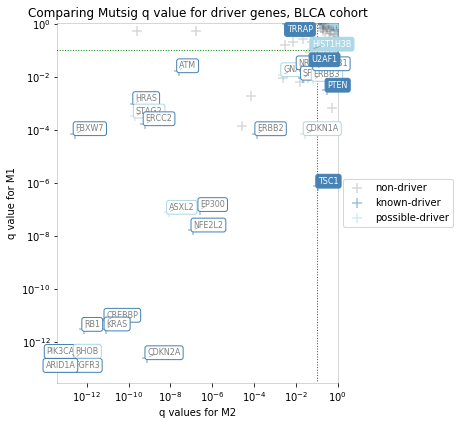

In [17]:
def scatter_q(cohort):

    df = compare_res(cohort, sig_only = False, fill = np.NaN, include_tier=None)

    df['tier'] = df.tier.astype('str').replace({'1.0': 'Known', '2.0': 'Known', '3.0': 'Highly possible',
                                             '4.0': np.NaN, '5.0': np.NaN, '6.0':np.NaN, 'nan': np.NaN}).astype('str')

    fig, ax = plt.subplots(1,1,figsize=(13,10))
    ax.set_yscale('log')
    ax.set_xscale('log')
    df_no = df.loc[df.tier == 'nan',:]
    df_known = df.loc[df.tier == 'Known',:]
    df_possi = df.loc[df.tier == 'Highly possible',:]

    ax.scatter(df_no['M1'], df_no['M2'], color = 'grey', 
               marker = "+", alpha = 0.3, s = 100, label = "non-driver")
    ax.scatter(df_known['M1'], df_known['M2'], 
               color = 'steelblue', s = 100, marker = '+', alpha = 0.5, label = "known-driver")
    ax.scatter(df_possi['M1'], df_possi['M2'], 
               color = 'lightblue', s = 100, marker = '+', alpha = 0.5, label = 'possible-driver')

    # lines
    ax.hlines(y=0.1, xmin=-0.05, xmax=1.05, color='green', linewidth=1, linestyles='dotted')
    ax.vlines(x=0.1, ymin=-0.05, ymax=1.05, color='red', linewidth=1, linestyles='dotted')


    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    plt.gca().spines["top"].set_alpha(.2)
    plt.gca().spines["bottom"].set_alpha(.2)
    plt.gca().spines["right"].set_alpha(.2)
    plt.gca().spines["left"].set_alpha(.2)

    annot1 = []
    for p1, p2, c, t in zip(df['M1'], df['M2'], df['symbol'], df['tier']):
        if np.isnan(p1) | np.isnan(p2) | (t  == 'nan'): 
            continue

        if ((p1 < 0.1) | (p2 < 0.1)) & (t == 'Known'):
            if (p1 < 0.1) & (p2 < 0.1):
                annot1.append(ax.text(p1, p2, c, alpha= 0.5, 
                                      bbox=dict(boxstyle="round", fc='w', color = 'steelblue'), #  alpha = 0.5),
                    horizontalalignment='right', verticalalignment='center', fontdict={'size':8}))
            else:
                annot1.append(ax.text(p1, p2, c, color = 'white', 
                                      bbox=dict(boxstyle="round", fc='steelblue', color = 'steelblue'),
                    horizontalalignment='right', verticalalignment='center', fontdict={'size':8}))

        elif ((p1 < 0.1) | (p2 < 0.1)) & (t == 'Highly possible'):
            if (p1 < 0.1) & (p2 < 0.1):
                annot1.append(ax.text(p1, p2, c, alpha= 0.5, 
                                      bbox=dict(boxstyle="round", fc='w', color = 'lightblue'), # alpha = 0.5),
                    horizontalalignment='right', verticalalignment='center', fontdict={'size':8}))
            else:
                annot1.append(ax.text(p1, p2, c, color = 'white', 
                                      bbox=dict(boxstyle="round", fc='lightblue', color = 'lightblue'),
                    horizontalalignment='right', verticalalignment='center', fontdict={'size':8}))

    adjust_text(annot1, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
    ax.set_position([0.1,0.1,0.3,0.5])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set(ylabel='q value for M1', xlabel = 'q values for M2')
    ax.set_title("Comparing Mutsig q value for driver genes, {} cohort".format(cohort), fontdict={'size':12})
    plt.savefig('/demo-mount/m2_results/combined_res/plots/mutsig3/{}-q.png'.format(cohort), dpi = 80)

scatter_q('BLCA')

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


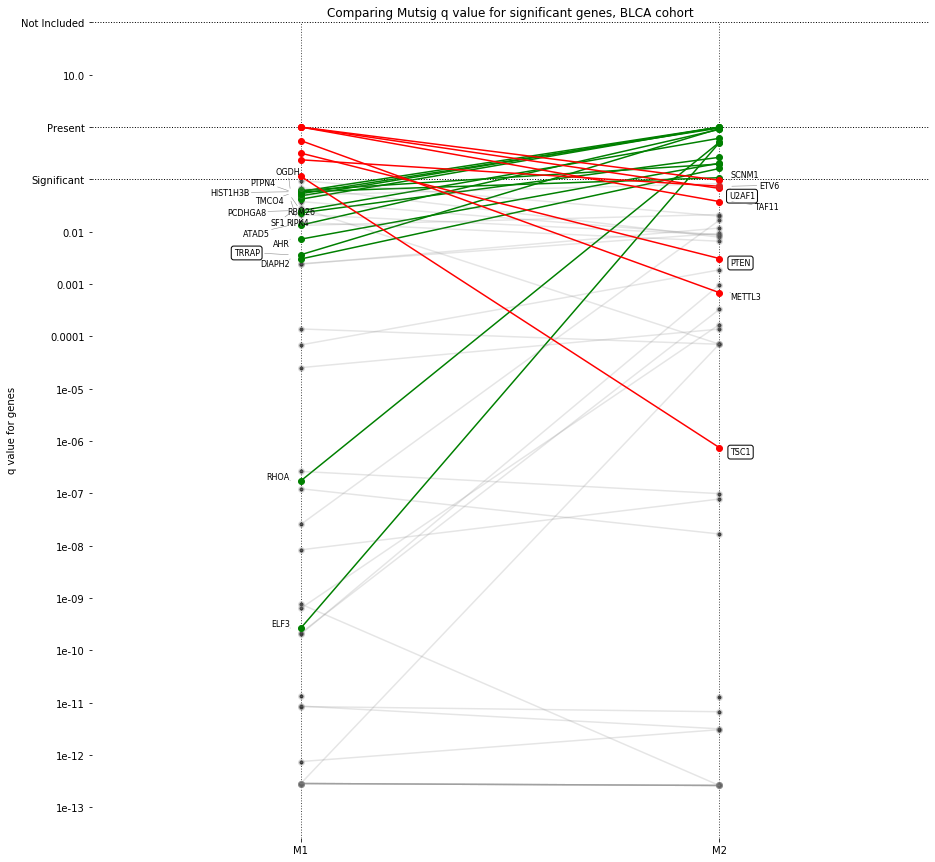

In [7]:
# line plot
import matplotlib.lines as mlines
from matplotlib import patches
from scipy.special import exp10
def plot_q2(cohort):
    df = compare_res(cohort, fill=np.nan, sig_only=True, include_tier=None )
    klass = ['red' if (y1-y2) < 0 else 'green' for y1, y2 in zip(df['M1'], df['M2'])]
    def newline(p1, p2, color='black'):
        alp = 1
        if (p1[1] < 0.1) & (p2[1]>= 0.1):
            col = "green"
        elif (p1[1] >= 0.1) & (p2[1]< 0.1):
            col = "red"
        else:
            col = "grey"
            alp = 0.2
        ax = plt.gca()
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color=col, 
                          marker='o', markersize=6, alpha = alp)
        ax.add_line(l)
        return l
    fig, ax = plt.subplots(1,1,figsize=(15,15))

    # Vertical Lines
    ax.vlines(x=1, ymin=0, ymax=100, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
    ax.vlines(x=3, ymin=0, ymax=100, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
    ax.hlines(y=0.1, xmin=0, xmax=4, color='black', linewidth=1, linestyles='dotted')
#     ax.text(0, 0.1, "Significant", horizontalalignment='right', verticalalignment='center', fontdict={'size':10})
    ax.hlines(y=100, xmin=0, xmax=4, color='black', linewidth=1, linestyles='dotted')
    ax.hlines(y=1, xmin=0, xmax=4, color='black', linewidth=1, linestyles='dotted')
    #ax.text(0, 1, "present", horizontalalignment='right', verticalalignment='center', fontdict={'size':8})
    
    # Points
    ax.scatter(y=df['M1'], x=np.repeat(1, df.shape[0]), s=10, color='black', alpha=0.7)
    ax.scatter(y=df['M2'], x=np.repeat(3, df.shape[0]), s=10, color='black', alpha=0.7)

    # Line Segmentsand Annotation
    annot1 = []
    annot2 = []
    for p1, p2, c, t in zip(df['M1'], df['M2'], df['symbol'], df['tier']):
        newline([1,p1], [3,p2])
        if (p1 < p2) & (p1 < 0.1) & (p2 >= 0.1):
            if t <= 2:
                #print(c)
                annot1.append(ax.text(1-0.05, p1, c, bbox=dict(boxstyle="round", fc="w"),
                horizontalalignment='right', verticalalignment='center', fontdict={'size':8}))
            else:
                annot1.append(ax.text(1-0.05, p1, c, 
                horizontalalignment='right', verticalalignment='center', fontdict={'size':8}))
        elif (p1 >= 0.1) & (p2 < 0.1):
            if t <= 2:
                #print(c)
                annot2.append(ax.text(3+0.05, p2, c, bbox=dict(boxstyle="round", fc="w"),
                horizontalalignment='left', verticalalignment='center', fontdict={'size':8}))
            elif cohort != "SKCM":
                annot2.append(ax.text(3+0.05, p2, c, 
                horizontalalignment='left', verticalalignment='center', fontdict={'size':8}))
    
    # add a patch
    patch = patches.Rectangle((1, 0), 2.05, 110, fill=False, alpha=0) 
    patch2 = patches.Rectangle((3.75,0), 5, 110, fill = False, alpha = 0)
    ax.add_patch(patch)
    ax.add_patch(patch2)
    
    # Decoration
    ax.set_title("Comparing Mutsig q value for significant genes, {} cohort".format(cohort), fontdict={'size':12})
    ax.set_xticks([1,3])
    ax.set_xticklabels(["M1", "M2"])
    plt.yscale('log')
    ax.set_yticks(exp10(-np.arange(-2,20)))
    #ax.set_xticklabels(["M1", "M2"])
    # Lighten borders
    plt.gca().spines["top"].set_alpha(.0)
    plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    plt.gca().spines["left"].set_alpha(.0)
#     plt.yscale('log')
    labels = [str(item) for item in ax.get_yticks().tolist()]
    
    new_labels = []
    for label in labels: 
        if len(label)> 10:
            label = str("{:.0e}".format(float(label)))
        if label == '100.0':
            label = 'Not Included'
        elif label == "1.0":
            label = "Present"
        elif label == "0.1":
            label = "Significant"
        new_labels.append(label)
    ax.set_yticklabels(new_labels)
    ax.set(xlim=(0,4), ylim=(min(min(df['M1']),min(df['M2']))*0.1, 100), ylabel='q value for genes')
    adjust_text(annot1, only_move={'points':'x', 'texts':'x','objects':'x'}, 
                ha = "left", add_objects=[patch], va='center',#force_objects=(1, 0),
                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
    adjust_text(annot2, only_move={'points':'x', 'texts':'x', 'objects':'x'}, 
                ha = "right", add_objects=[patch, patch2], va='center',#expand_text=(7, 0.9),
                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
    plt.savefig('/demo-mount/m2_results/combined_res/plots/mutsig2/{}-q.png'.format(cohort), dpi = 80)

plot_q2("BLCA")

In [8]:
dd = get_diff_driver_calls('BLCA')
dd.symbol.value_counts() # matches the plot

/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/home/qing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  


TRRAP    26
TSC1     13
U2AF1     5
PTEN      5
Name: symbol, dtype: int64

In [13]:
dirs = ["ACC", "LAML", "BLCA", "LIHC", "BRCA", "MESO", "CESC", "SARC", "CHOL", "SKCM", "COAD", "TGCT", "DLBC", "THYM", "ESCA", "UCS", "KICH"]

for cc in dirs:
    print(cc)
    if cc == "LAML":
        continue
    pass
#     scatter_q(cc)
#     plot_q2(cc)
#     get_diff_driver_calls(cc)

ACC
LAML
BLCA
LIHC
BRCA
MESO
CESC
SARC
CHOL
SKCM
COAD
TGCT
DLBC
THYM
ESCA
UCS
KICH


In [18]:
dd

,patient,symbol,chr,pos,effect_M1,sig_in,effect_M2,filters
0,TCGA-XF-A8HF-01A-11D-A364-08,TRRAP,7,98543382,missense,M1,flank,NaN
1,TCGA-BL-A13J-01A-11D-A271-08,TRRAP,7,98550854,missense,M1,NaN,map_qual;orientation;strand_bias;weak_evidence
2,TCGA-FD-A3SS-01A-12D-A22Z-08,TRRAP,7,98581089,missense,M1,NaN,NaN
3,TCGA-BT-A42F-01A-11D-A23U-08,TRRAP,7,98588099,missense,M1,NaN,strand_bias
4,TCGA-UY-A9PD-01A-11D-A38G-08,PTEN,10,89624120,flank,M2,NaN,NaN
5,TCGA-ZF-A9R4-01A-11D-A38G-08,TSC1,9,135771509,flank,M2,NaN,NaN
6,TCGA-GC-A4ZW-01A-11D-A26M-08,TSC1,9,135771553,flank,M2,NaN,NaN
7,TCGA-4Z-AA80-01A-11D-A391-08,TSC1,9,135781382,missense,M2,NaN,clustered_events;haplotype
8,TCGA-4Z-AA80-01A-11D-A391-08,TSC1,9,135781386,nonsense,M2,NaN,clustered_events;haplotype
9,TCGA-4Z-AA80-01A-11D-A391-08,TSC1,9,135781405,slience,M2,NaN,clustered_events
